In [1]:

!ls

 DefectModel_simulate_curr_3_vacancy_single_large
 DefectModel_weights_simulate_curr_3_vacancy_single_large.h5
 image0_3.tiff
 image0_5.tiff
'new_pattern Se+Vacancy 0.tif'
 sample_data


In [0]:


#I/O
import os

import h5py
from sklearn.externals import joblib

#graphics
import matplotlib
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import matplotlib.gridspec as gridspec
import pylab as P


#processing 
import numpy as np
from scipy import fftpack
from scipy import ndimage

from skimage.feature import blob_log
from sklearn import cluster, mixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from collections import OrderedDict
from scipy.spatial import cKDTree

In [3]:
import cv2
#neural networks
from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers import Dropout, Activation, Reshape
from keras.models import Model, load_model
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [0]:
plt.rcParams['figure.figsize'] = (25, 16)

In [0]:
def normalize(image):
  return (image-np.min(image))/np.ptp(image)
def change_label(label_image):
  label_image1 = label_image.copy()
  sel = label_image1 <100
  label_image1[sel] = 0
  sel = label_image1 >0
  label_image1[sel] = 1
  return label_image1

In [0]:
train_image1 = normalize(plt.imread('./image0_5.tiff'))
label1 = plt.imread('./new_pattern Se+Vacancy 0.tif')

In [0]:
train_normalize1 = normalize(train_image1)
label_image1 = change_label(label1)


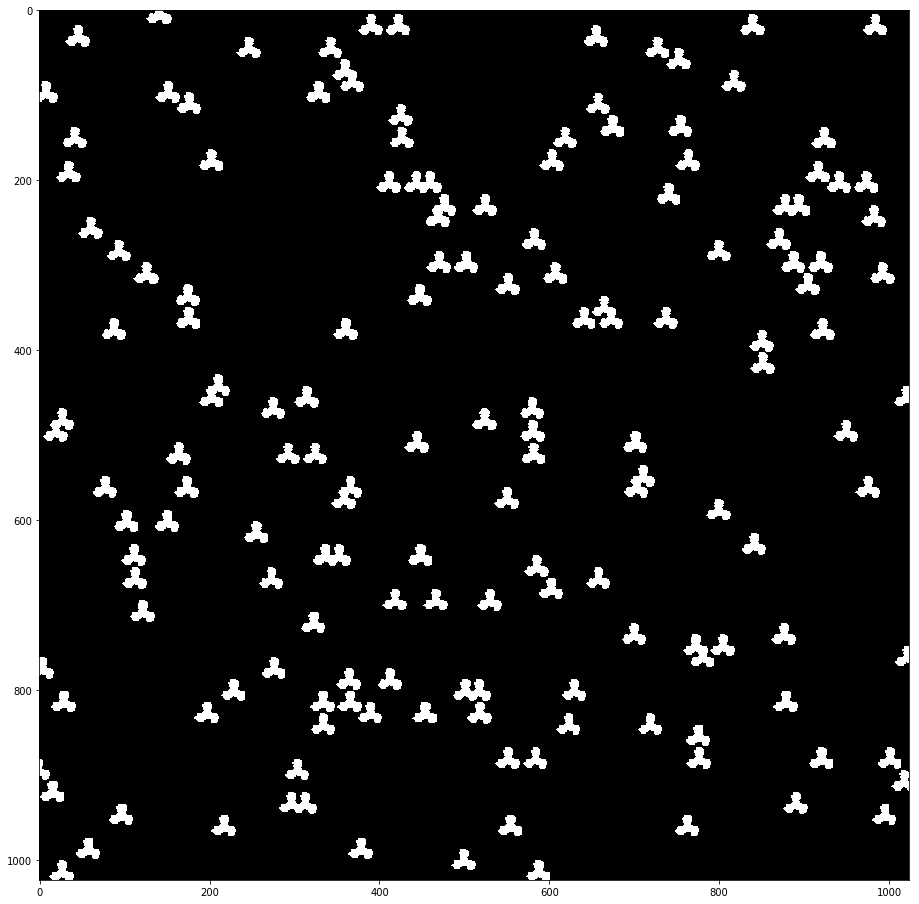

In [10]:
plt.imshow(label_image1,cmap = 'gray')

In [0]:
def GenerateXYPos(window_size, window_step, image_width):
    """Takes the window size, step, and total image width 
    and generates all xy pairs for sliding window"""   
    xpos_vec = np.arange(0,image_width-window_size,window_step)
    ypos_vec = np.arange(0,image_width-window_size,window_step)
        
    num_steps = len(xpos_vec)    
            
    xpos_mat = np.tile(xpos_vec, num_steps)
    ypos_mat = np.repeat(ypos_vec, num_steps)
    pos_mat = np.column_stack((xpos_mat, ypos_mat))
            
    return pos_mat

In [0]:
def MakeWindow(imgsrc, xpos, ypos, window_size):
    """returns window of given size taken at position on image"""
    imgsrc = imgsrc[xpos:xpos+window_size, ypos:ypos+window_size]
    return imgsrc

In [0]:
def imgen(raw_image, pos_mat, window_size):
    """Returns all windows from image for given positions array"""
    
    immat = np.zeros(shape = (len(pos_mat), window_size, window_size))
    
    for i in np.arange(0,len(pos_mat)):
        img_window = MakeWindow(raw_image, pos_mat[i,0], pos_mat[i,1], window_size) 
        immat[i,:,:,] = img_window
    
    return immat

In [0]:
def image_preprocessing(image_data, norm=0):
    """Reshapes data and optionally normalizes it"""
    image_data = image_data.reshape(image_data.shape[0], image_data.shape[1], image_data.shape[2], 1)
    image_data = image_data.astype('float32')
    if norm != 0:
        image_data = (image_data - np.amin(image_data))/(np.amax(image_data) - np.amin(image_data))
    return image_data

In [0]:
def label_preprocessing(image_data, nb_classes):
    """Returns labels / ground truth for images"""
    
    label4D = np.empty((0, image_data.shape[1], image_data.shape[2], nb_classes))
    for idx in range(image_data.shape[0]):
        img = image_data[idx,:,:]
        n, m = img.shape
        img = np.array(OneHotEncoder(n_values=nb_classes).fit_transform(img.reshape(-1,1)).todense())
        img = img.reshape(n, m, nb_classes)
        label4D = np.append(label4D, [img], axis = 0)    
    return label4D

In [0]:
def label_preprocessing2(image_data):
    """we can simplify this in case of only two classes"""
    
    label1 = image_data.reshape(image_data.shape[0], image_data.shape[1], image_data.shape[2], 1)
    label2 = -label1 + 1
    label4D = np.concatenate((label2, label1), axis = 3)
    return label4D

In [17]:
window_size = 256
window_step = 16
pos_mat = GenerateXYPos(window_size, window_step, train_image1.shape[0])
print("On image size: ", train_image1.shape[0], ' by ',  train_image1.shape[1], ' pixels: ', len(pos_mat), "patches will be generated")

On image size:  1024  by  1024  pixels:  2304 patches will be generated


In [18]:
immat1 = imgen(train_normalize1, pos_mat, window_size)
labelmat1 = imgen(label_image1, pos_mat, window_size)
print(np.shape(immat1))
print(np.shape(labelmat1))

(2304, 256, 256)
(2304, 256, 256)


In [19]:
immat21 =  image_preprocessing(immat1, 1)
labelmat21 =  label_preprocessing2(labelmat1)
print(np.shape(immat21))
print(np.shape(labelmat21))

(2304, 256, 256, 1)
(2304, 256, 256, 2)


In [0]:
def model_defect(input_img, nb_classes = 2):
    """Creates a Deep Learning model for defect identification"""
    
    x = Convolution2D(20, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Convolution2D(40, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
        
    x = Convolution2D(40, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Convolution2D(20, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Convolution2D(nb_classes, (3, 3), activation = 'linear', padding='same')(x)
    x = Convolution2D(nb_classes, (1, 1), activation = 'linear', padding='same')(x)

    output = Activation('softmax')(x)
    
    return Model(input_img, output)

In [0]:
nb_classes = 2
target_size = (256, 256)

X_train, X_test, y_train, y_test = train_test_split(immat21, labelmat21, test_size = 0.2, random_state = 42)

In [22]:
input_img = Input(shape=(target_size[0], target_size[1], 1)) 

model = model_defect(input_img)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
callback_tb = TensorBoard(log_dir='/tmp/AtomGen', histogram_freq=0,
                          write_graph=True, write_images=False)

model.fit(X_train, y_train, epochs=35, batch_size=32, 
          validation_data=(X_test, y_test), shuffle=True, verbose = 1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1843 samples, validate on 461 samples
Epoch 1/35
1843/1843 [==============================] - 13s 7ms/step - loss: 0.2975 - acc: 0.9392 - val_loss: 0.2275 - val_acc: 0.9398
Epoch 2/35
1843/1843 [==============================] - 8s 4ms/step - loss: 0.2243 - acc: 0.9398 - val_loss: 0.2185 - val_acc: 0.9398
Epoch 3/35
1843/1843 [==============================] - 8s 4ms/step - loss: 0.2130 - acc: 0.9398 - val_loss: 0.2094 - val_acc: 0.9398
Epoch 4/35
1843/1843 [==============================] - 8s 4ms/step - loss: 0.2075 - acc: 0.9398 - val_loss: 0.2050 - val_acc: 0.9398
Epoch 5/35
1843/1843 [==============================] - 8s 4ms/step - loss: 0.2018 - acc: 0.9398 - val_loss: 0.1984 - val_acc: 0.9398
Epoch 6/35
1843/1843 [==============================] - 8s 4ms/step - loss: 0.1963 -

In [23]:
model.save("./DefectModel_simulate_curr_5_vacancy_single_large")
model.save_weights("./DefectModel_weights_simulate_curr_5_vacancy_single_large.h5")
print('Saved model and weights to disk.\n')

Saved model and weights to disk.



In [0]:
model = load_model("./DefectModel_simulate_with_bkg")
model.load_weights("./DefectModel_weights_simulate_with_bkg.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [0]:
def splitImage(img, target_size):
    """Splits image into patches with given size"""
    
    xs = img.shape[0]
    ys = img.shape[1]
    nxp = int(xs/target_size[0])
    nyp = int(xs/target_size[1])
    
    impatchmat = np.zeros(shape=(int(nxp*nyp), target_size[0], target_size[1], 1))
    
    count = 0
    for i in range(nxp):
        for i2 in range(nyp):
            xstart = target_size[0] * i
            ystart = target_size[1] * i2
            xend = target_size[0] * (i + 1)
            yend = target_size[1] * (i2 + 1)

            impatchmat[count, :, :, 0] = img[xstart:xend, ystart:yend]
            count = count + 1
            
    return impatchmat

In [0]:
def predictDefects(img, model, target_size, nb_classes=2):
    """Uses given DL model to generate prediciton maps on the image"""
    
    xs = img.shape[0]
    ys = img.shape[1]
    nxp = int(xs/target_size[0])
    nyp = int(xs/target_size[1])
    classpred = np.zeros(shape=(nb_classes,xs, ys))

    impatchmat = splitImage(img, target_size)
    res = model.predict(impatchmat)
    
    count = 0
    for i in range(nxp):
        for i2 in range(nyp):
            xstart = target_size[0] * i
            ystart = target_size[1] * i2
            xend = target_size[0] * (i + 1)
            yend = target_size[1] * (i2 + 1)
            
            for i3 in range(nb_classes):
                classpred[i3, xstart:xend, ystart:yend] = res[count, :, :, i3]
                
            count = count + 1
            
    return classpred

In [0]:
def sameBC(image1, image2):
  image11 = image1.copy()
  #image1_std, image2_std = np.std(image11),np.std(image2)
  #image11 = image11 *image2_std/image1_std
  #image1_mean, image2_mean = np.mean(image11), np.mean(image2)
  #image11 += image2_mean - image1_mean
  x,y = np.shape(image1)
  x1,y1 = np.shape(image2)
  new_image = np.zeros((x1,y1))
  new_image[:x,:y]=  image11
  return new_image

In [0]:
test_image1 = normalize(plt.imread('./image1_5.tiff'))
test_label1 = plt.imread('./new_pattern Se+Vacancy 1.tif')

In [0]:
classpred1 = predictDefects(test_image1, model, target_size, nb_classes)

In [29]:
fig301 = plt.figure(301)
ax1 = fig301.add_subplot(121)
ax1.imshow(test_image1,cmap = 'gray')
ax1.axis('off')
ax1.set_title('current 3 original')
ax2 = fig301.add_subplot(122)
ax2.imshow(test_image1,cmap = 'gray')
ax2.imshow(classpred1[1], cmap='hot', alpha=0.5)
ax2.set_title('curr 3 prediction')
ax2.axis('off')

Output hidden; open in https://colab.research.google.com to view.

Text(0.5, 1.0, 'cur_3 predict')

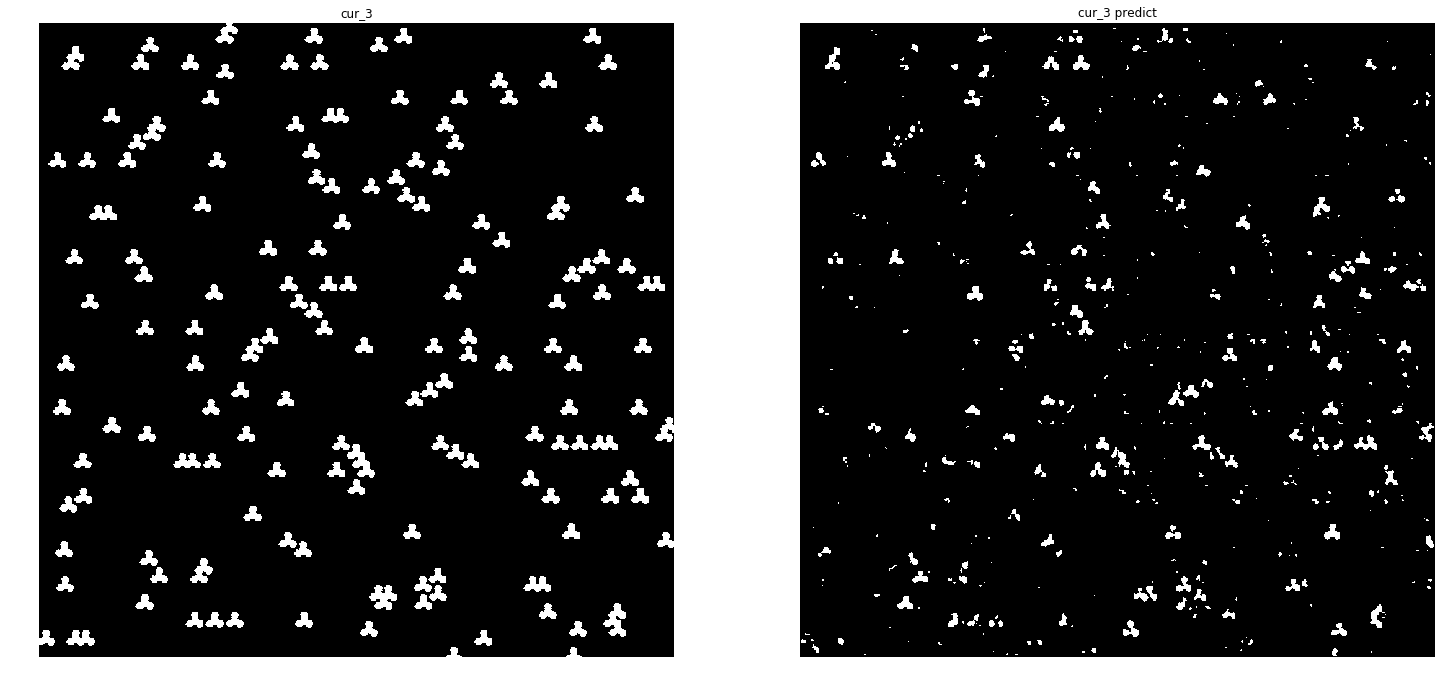

In [31]:
fig300 = plt.figure(300)
ax1 = fig300.add_subplot(121)
ax1.imshow(test_label1,cmap = 'gray')
ax1.axis('off')
ax1.set_title('cur_3')
ax2 = fig300.add_subplot(122)
ax2.imshow(classpred1[1,:,:]>0.9,cmap = 'gray')
ax2.axis('off')
ax2.set_title('cur_3 predict')

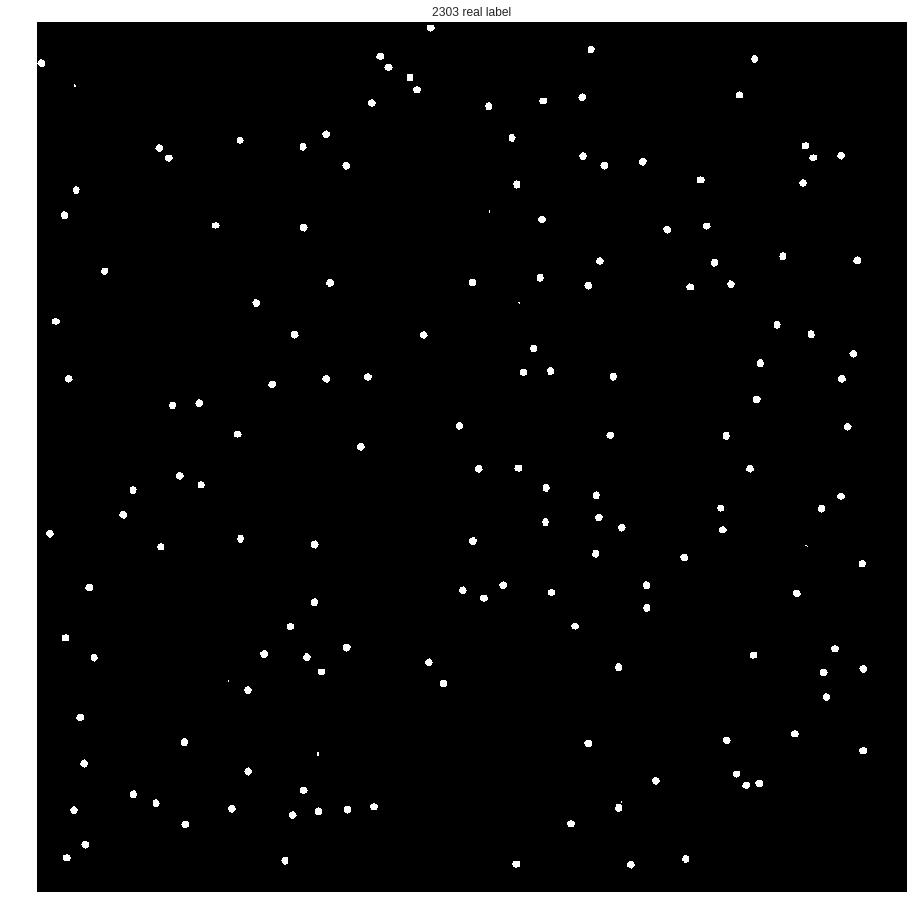

In [0]:
yplt.imshow(change_label(test_label1),cmap = 'gray')
plt.title("2303 real label")
plt.axis('off')
plt.show()

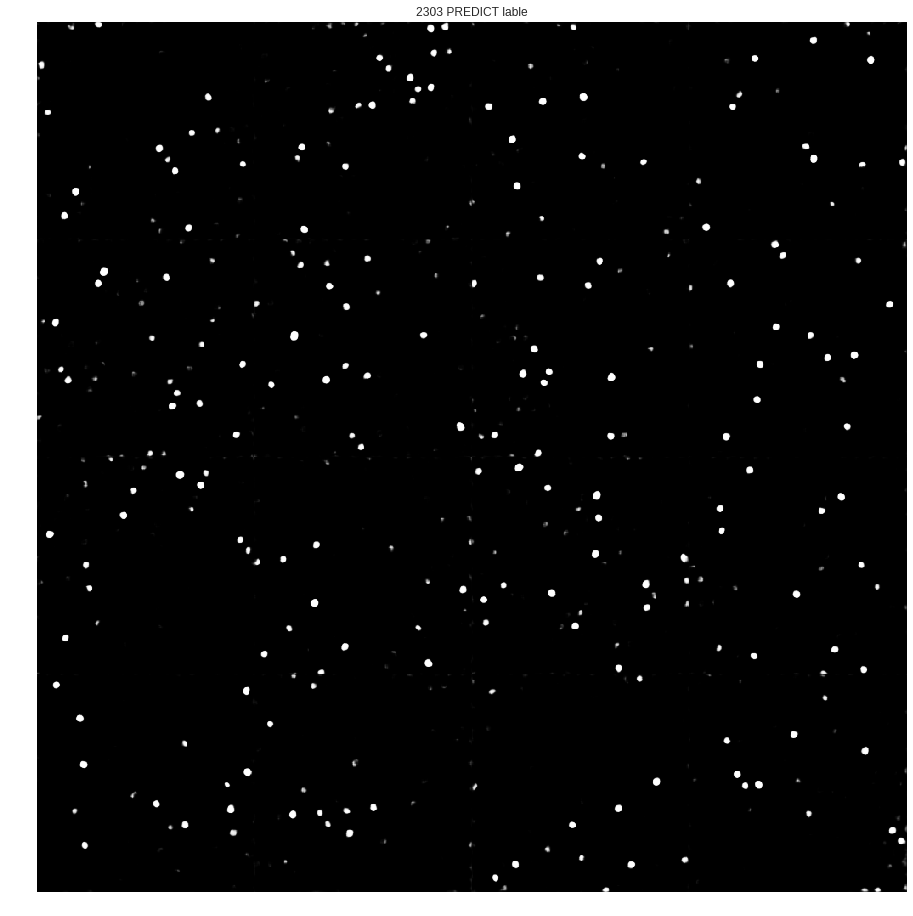

In [0]:
plt.imshow(classpred1[1,:,:],cmap = 'gray')
plt.title("2303 PREDICT lable")
plt.axis('off')
plt.show()

In [0]:
test_image2 = normalize(plt.imread('./2306 HAADF 4.6 Mx HAADF.tif'))
test_label2 = plt.imread('./2306 HAADF 4.6 Mx HAADF 2Te.tif')
classpred2 = predictDefects(test_image2, model, target_size, nb_classes)

Text(0.5, 1.0, '2306 predict label')

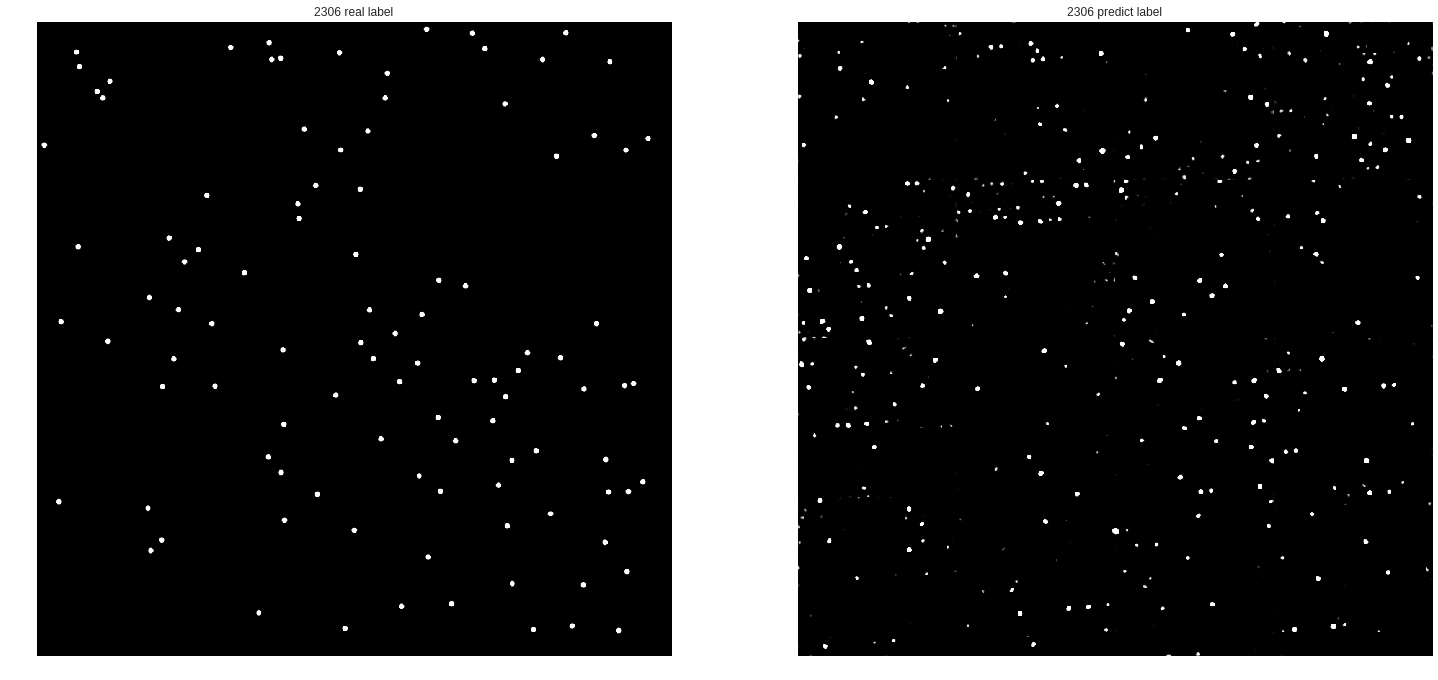

In [0]:
fig300 = plt.figure(300)
ax1 = fig300.add_subplot(121)
ax1.imshow(test_label2,cmap = 'gray')
ax1.axis('off')
ax1.set_title('2306 real label')
ax2 = fig300.add_subplot(122)
ax2.imshow(classpred2[1,:,:],cmap = 'gray')
ax2.axis('off')
ax2.set_title('2306 predict label')

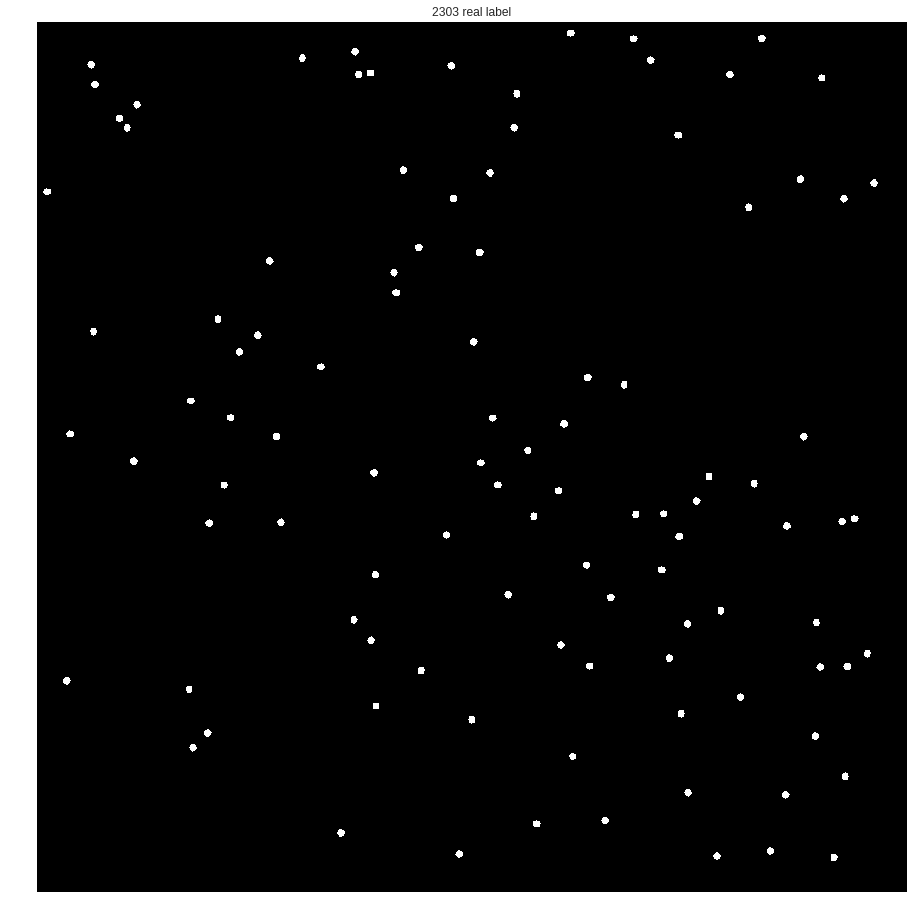

In [0]:
plt.imshow(change_label(test_label2),cmap = 'gray')
plt.title("2303 real label")
plt.axis('off')
plt.show()

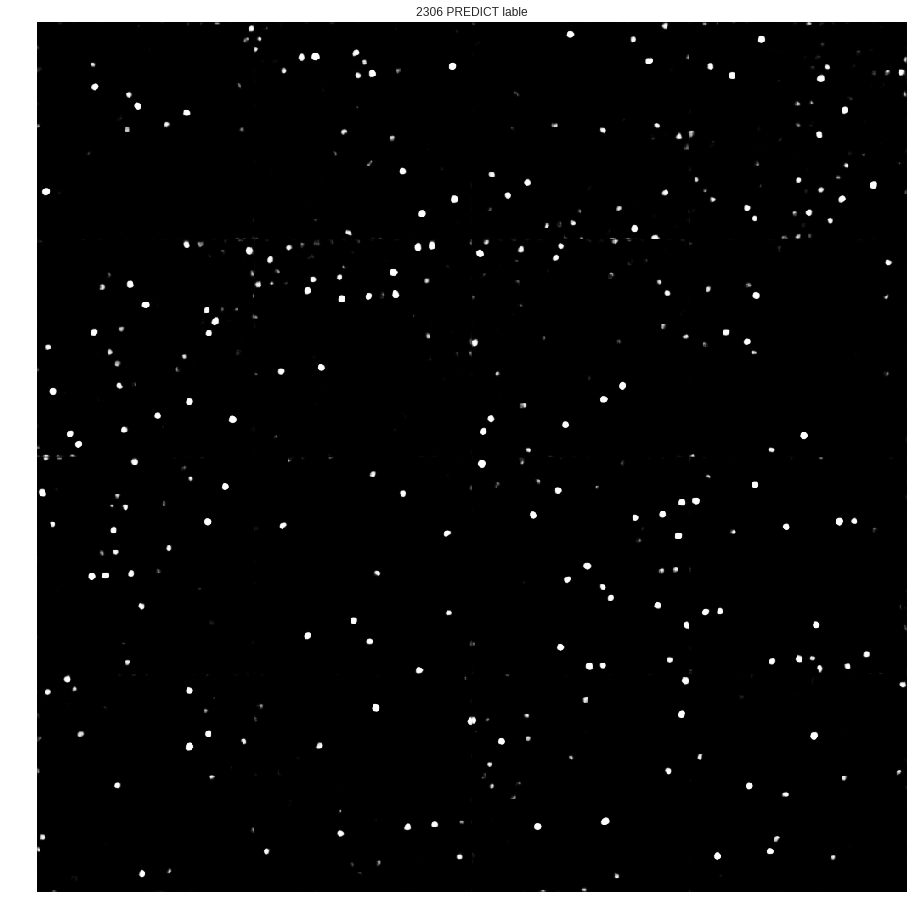

In [0]:
plt.imshow(classpred2[1,:,:],cmap = 'gray')
plt.title("2306 PREDICT lable")
plt.axis('off')
plt.show()

(-0.5, 1023.5, 1023.5, -0.5)

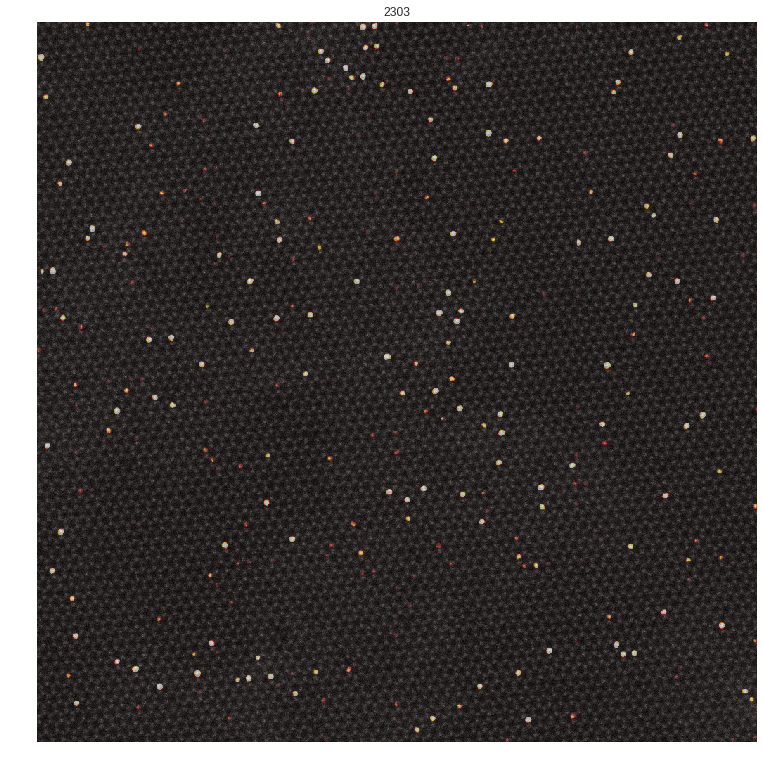

In [0]:
fig301 = plt.figure(301, figsize=(10,10))
ax = fig301.add_axes([0, 0, 1, 1])

ax.imshow(test_image2,cmap = 'gray')
ax.imshow(classpred2[1], cmap='hot', alpha=0.5)
ax.set_title('2303')
ax.axis('off')

In [0]:
test_image3 = normalize(plt.imread('./2306 HAADF 4.6 Mx HAADF.tif'))
test_label3 = plt.imread('./2306 HAADF 4.6 Mx HAADF 2Te.tif')
classpred3 = predictDefects(test_image3, model, target_size, nb_classes)

Text(0.5, 1.0, '2306 predict label')

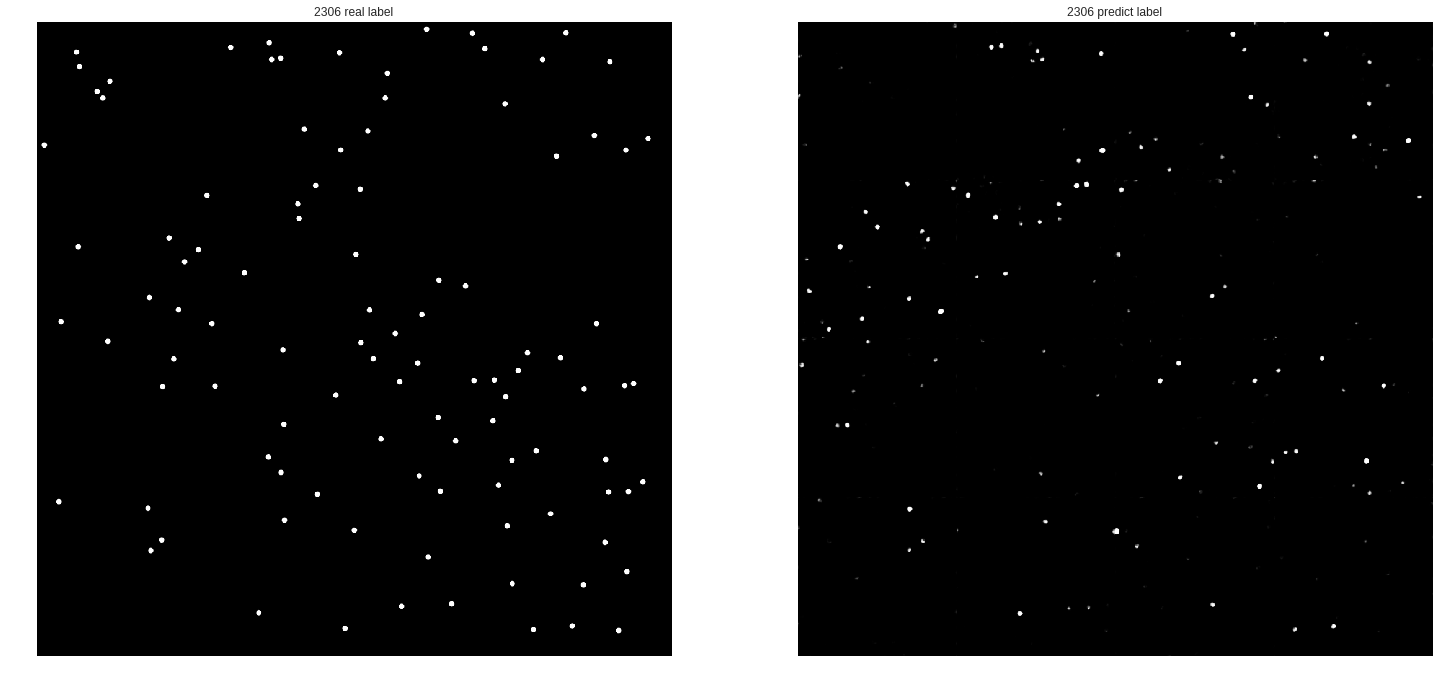

In [0]:
fig300 = plt.figure(300)
ax1 = fig300.add_subplot(121)
ax1.imshow(test_label3,cmap = 'gray')
ax1.axis('off')
ax1.set_title('2306 real label')
ax2 = fig300.add_subplot(122)
ax2.imshow(classpred3[1,:,:],cmap = 'gray')
ax2.axis('off')
ax2.set_title('2306 predict label')

(-0.5, 1023.5, 1023.5, -0.5)

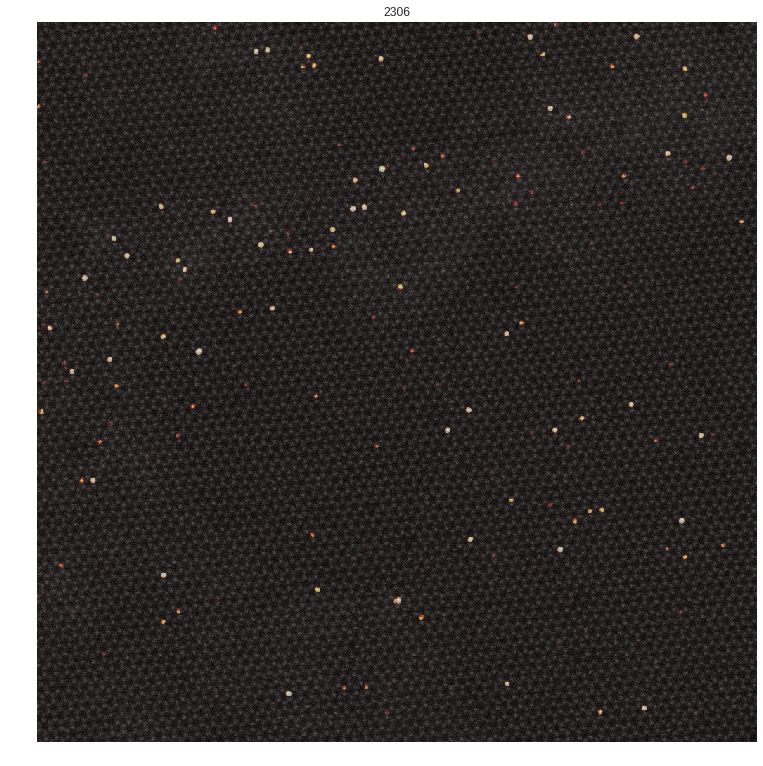

In [0]:
fig301 = plt.figure(301, figsize=(10,10))
ax = fig301.add_axes([0, 0, 1, 1])

ax.imshow(test_image3,cmap = 'gray')
ax.imshow(classpred3[1], cmap='hot', alpha=0.5)
ax.set_title('2306')
ax.axis('off')

In [0]:
def sameBC(image1, image2):
  image1_std, image2_std = np.std(image1),np.std(image2)
  image1 *= image2_std/image1_std
  image1_mean, image2_mean = np.mean(image1), np.mean(image2)
  image1 += image2_mean - image1_mean
  x,y = np.shape(image1)
  image1 = np.pad(image1,((1024-x)//2,(1024-y)//2+1),'constant')
  return image1

In [0]:
test_image3 = normalize(plt.imread('./RR_2257_10frame.tif'))
test_label3 = plt.imread('./RR_2304_10frame_2Te.tif')

In [0]:
test_image3 = sameBC(test_image3,train_normalize1)
print(np.shape(test_image3))

(1025, 1024)


In [0]:
classpred3 = predictDefects(test_image3[:1024,:1024], model, target_size, nb_classes)

Text(0.5, 1.0, '2306 predict label')

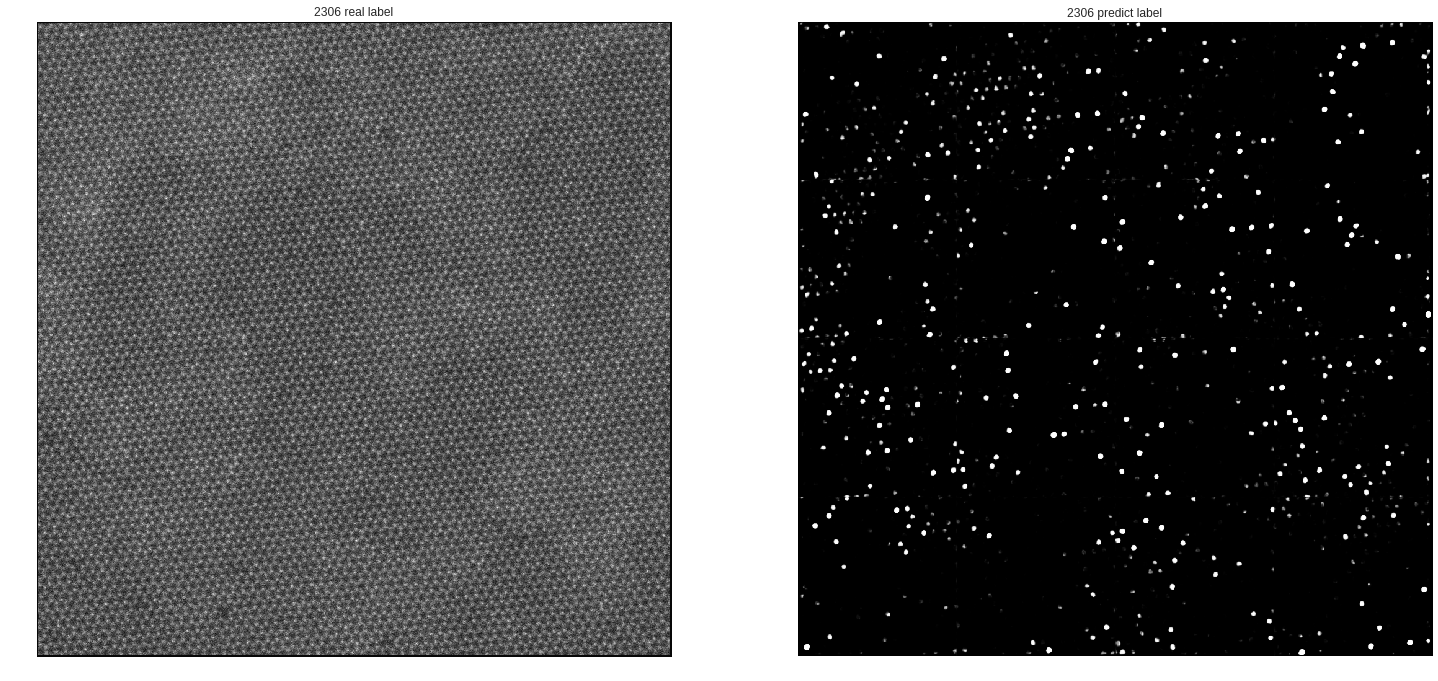

In [0]:
fig300 = plt.figure(300)
ax1 = fig300.add_subplot(121)
ax1.imshow(test_image3,cmap = 'gray')
ax1.axis('off')
ax1.set_title('2306 real label')
ax2 = fig300.add_subplot(122)
ax2.imshow(classpred3[1,:,:],cmap = 'gray')
ax2.axis('off')
ax2.set_title('2257 predict label')

In [0]:
sel = classpred3[1,:,:]<0.99
classpred3[1,:,:][sel] = 0

Text(0.5, 1.0, '2306 predict label')

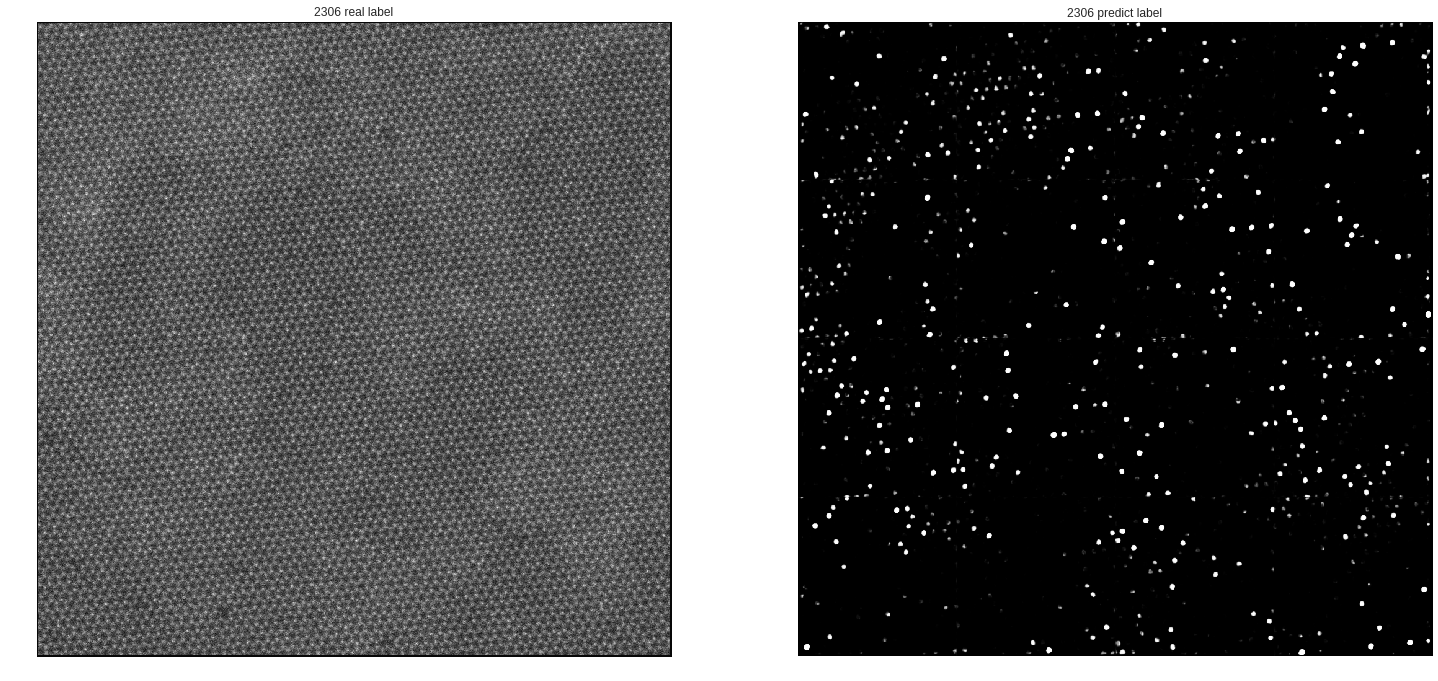

In [0]:
fig300 = plt.figure(300)
ax1 = fig300.add_subplot(121)
ax1.imshow(test_image3,cmap = 'gray')
ax1.axis('off')
ax1.set_title('2306 real label')
ax2 = fig300.add_subplot(122)
ax2.imshow(classpred3[1,:,:],cmap='gray')
ax2.axis('off')
ax2.set_title('2306 predict label')

In [0]:
!pip install tifffile

    100% |████████████████████████████████| 133kB 6.3MB/s 


In [0]:
import tifffile

In [0]:
plt.imsave('./RR_2257_2Te3.tif',classpred3[0,:,:])

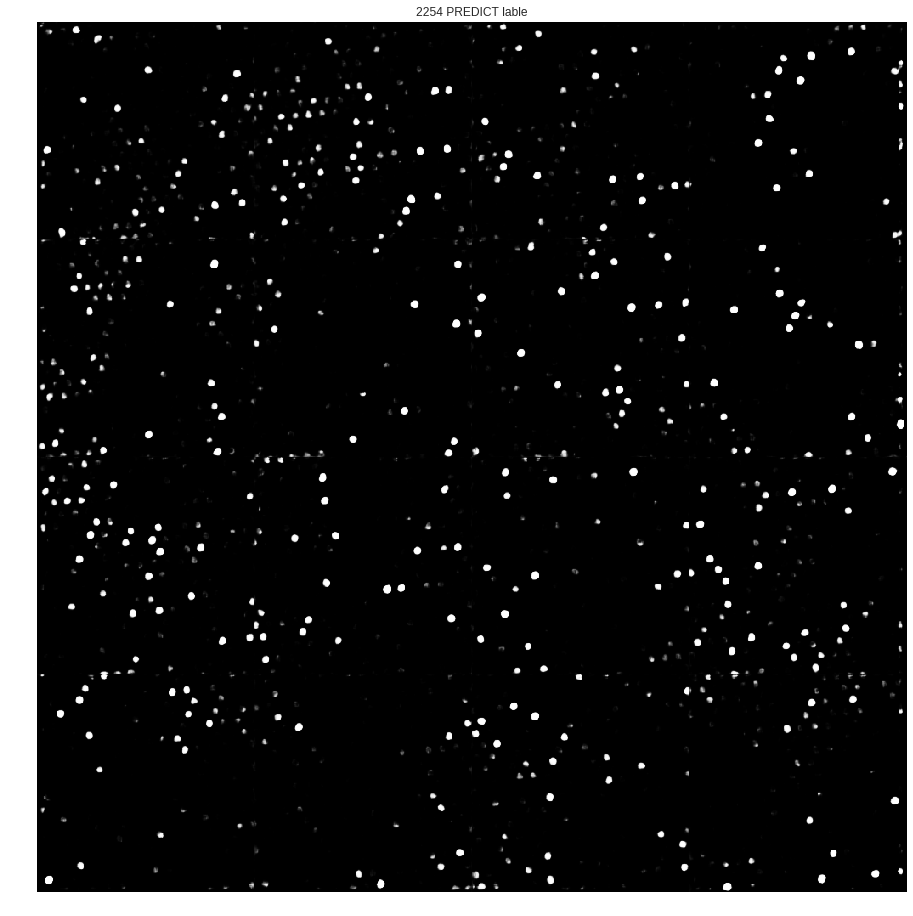

In [0]:
plt.imshow(classpred3[0,:,:])
plt.title("2254 PREDICT lable")
plt.axis('off')
plt.show()

(-0.5, 1023.5, 1023.5, -0.5)

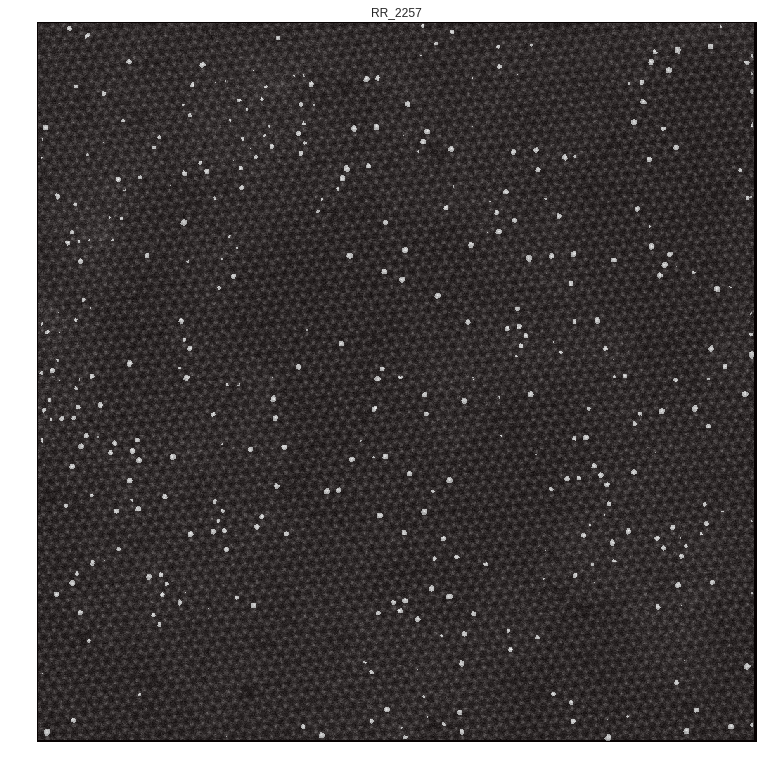

In [0]:
fig301 = plt.figure(301, figsize=(10,10))
ax = fig301.add_axes([0, 0, 1, 1])

ax.imshow(test_image3,cmap = 'gray')
ax.imshow(classpred3[1] > 0.8, cmap='hot', alpha=0.5)
ax.set_title('RR_2257')
ax.axis('off')